Import packages

In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima, StepwiseContext, nsdiffs
import datetime as dt

Import Financial Data and prepare datasets

In [2]:
symbols = ["BTC-USD", "GOOG", "MSFT", "KCHOL.IS", "BEEF3.SA", "PAM", "CMTOY", "IMP.JO"]

# Pull the data from January 2020 to current date
tickers = yf.Tickers(" ".join(symbols))

# Create a dictionary of Dataframes
hist = {}
for symbol in symbols:
    history = tickers.tickers[symbol].history(start="2020-01-01")
    history.rename(columns={'Open': 'y'}, inplace=True) # fbprophet will detect 'y' column
    history.index.rename('ds', inplace=True) # fbprophet will detect 'ds' dates
    history.reset_index(inplace=True) # Dates are now a column rather than an index (necessary with fbprophet)
    history['ds'] = history['ds'].dt.tz_localize(None)
    hist[symbol] = history

The parameter d in ARIMA is the order of differencing needed for the time series to reach stationarity. The "Integrated" part of the ARIMA name refers to this differencing process.

The following blocks aims at determining that parameter for each time series considered using the Augmented Dickey Fuller (ADF) Test. A p-value below 0.05 rejects the null hypothesis that the tested series is not stationary.

In [3]:
d_list = []
for symbol in symbols:
    print('\n Testing data for: ', symbol)
    history = hist[symbol][['ds', 'y']]
    df = history.set_index('ds').squeeze()
    df.index = pd.DatetimeIndex(df.index).to_period('D')

    result = adfuller(df.dropna())
    print('\nAugmented Dickey Fuller Test applied to the seriess differentiated 0 time')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < 0.05:
        d = 0
        print(f'\nd is selected to be {d}')
    else:
        print('\nAugmented Dickey Fuller Test applied to the series differentiated 1 time')
        result = adfuller(df.diff().dropna())
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        assert result[1] < 0.05
        d = 1
        print(f'\nd is selected to be {d}')
    d_list.append(d)
print('\nA list is saved with the minimum d value the ADF tests concluded on for each time series')
print(f'\n{d_list = }')


 Testing data for:  BTC-USD

Augmented Dickey Fuller Test applied to the seriess differentiated 0 time
ADF Statistic: -1.797760
p-value: 0.381574

Augmented Dickey Fuller Test applied to the series differentiated 1 time
ADF Statistic: -11.755368
p-value: 0.000000

d is selected to be 1

 Testing data for:  GOOG

Augmented Dickey Fuller Test applied to the seriess differentiated 0 time
ADF Statistic: -1.676226
p-value: 0.443401

Augmented Dickey Fuller Test applied to the series differentiated 1 time
ADF Statistic: -32.214282
p-value: 0.000000

d is selected to be 1

 Testing data for:  MSFT

Augmented Dickey Fuller Test applied to the seriess differentiated 0 time
ADF Statistic: -1.473211
p-value: 0.546719

Augmented Dickey Fuller Test applied to the series differentiated 1 time
ADF Statistic: -15.949335
p-value: 0.000000

d is selected to be 1

 Testing data for:  KCHOL.IS

Augmented Dickey Fuller Test applied to the seriess differentiated 0 time
ADF Statistic: 2.656754
p-value: 0.99

The parameter p is the order of the Auto Regressive (AR) term, that is the number previous values (lags) in the time series deemed to be necessary to account for to predict the next time step value with a linear combination of these lags.

Next, the Partial Autocorrelation Test (PACF) is used to determine the right p value for each time series. It is said to be "partial" because only the correlation between the series and a specific lag is calculated, after excluding the contributions from the intermediate lags.

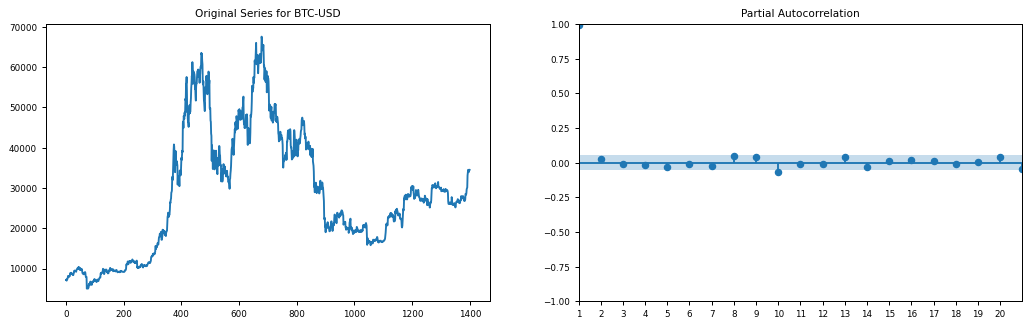

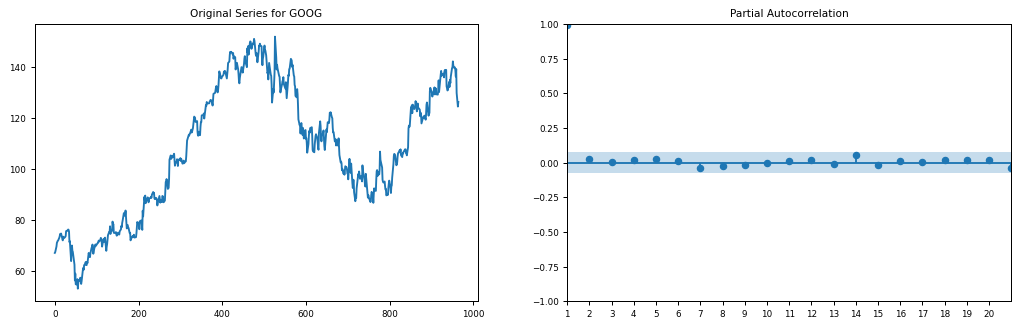

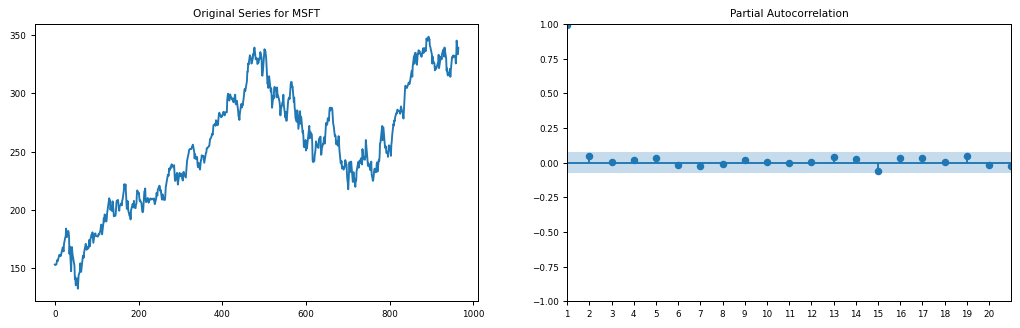

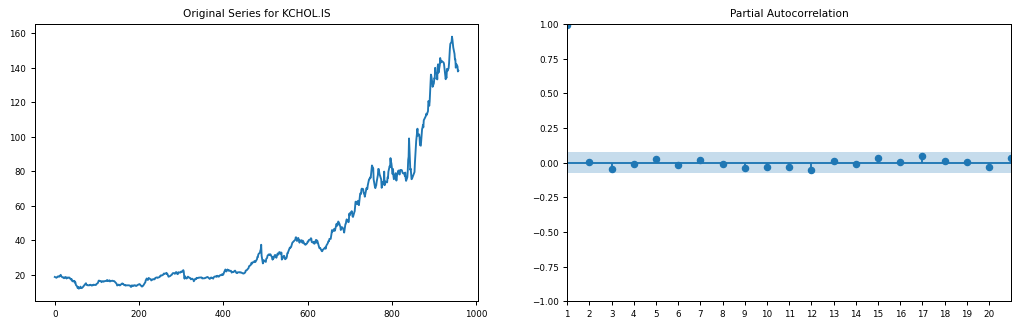

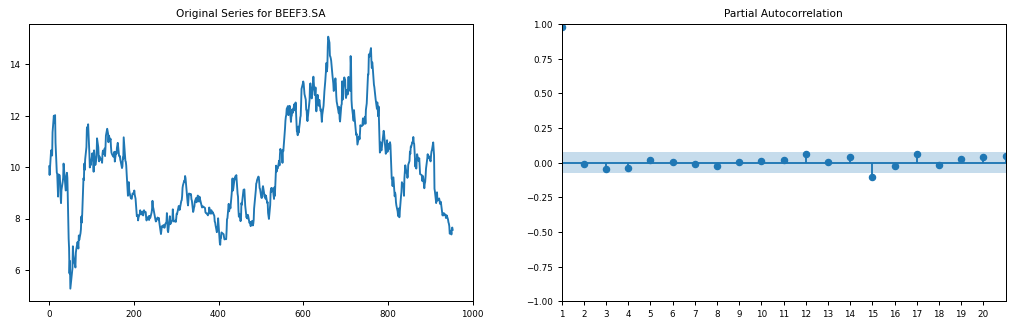

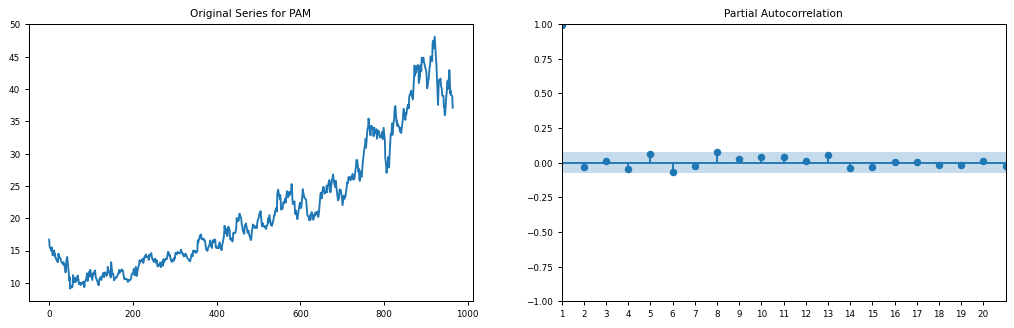

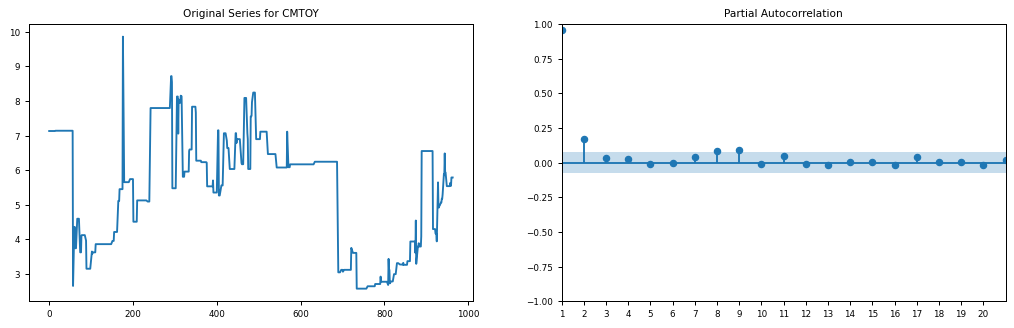

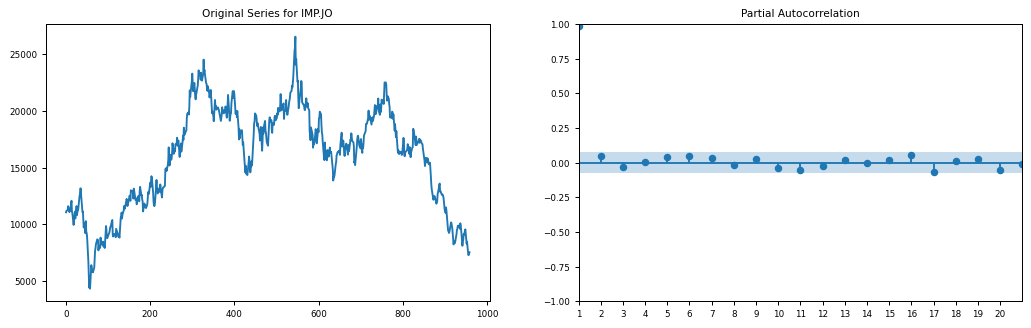

In [4]:
# PACF plot of original series
plt.rcParams.update({'figure.figsize':(14,4), 'figure.dpi':90, 'font.size':7})

for symbol in symbols:
    history = hist[symbol][['ds', 'y']]
    initial_date = history['ds'].iloc[0]
    example_df = pd.Series(index = history['ds'].map(lambda x: (x-initial_date).days), data = history['y'])
    
    fig, ax = plt.subplots(1, 2)
    
    # ax[0].set_xlim(dt.datetime(2020,1,1), dt.datetime(2023,11,1))
    ax[0].plot(example_df)
    ax[0].set_title(f'Original Series for {symbol}')
    ax[1].set_xlim(1, 21)
    ax[1].set_xticks(list(np.arange(1,21)))
    ax[1].set(ylim=(0,5))
    plot_pacf(example_df.dropna(), ax=ax[1])

plt.show()

Since only the differenced series can be considered stationary, only the PACF tests for the differenced series are used to select p and the tests for the original series are just for illustration. The index of the last lag to be correlated to the time series next value (correlation score outside of the band) is equal to the p value.

For every time series considered, all the lags are concluded to be decorrelated from the next value, which leads to a p value of 0 (no Auto Regressive component). This also suggests that the linearity of the model might be too simplistic to analyse these times series since no correlation with the lags was found.

Now, the parameter q is the order of the Moving Average (MA) component of the model. An MA model of order q interprets the time series to fluctuates around an average according to a linear combination of decorrelated disturbances for the current time step and for the q previous time steps.

The Autocorrelation Test (ACF) can be used to determine the right q value for each time series. The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

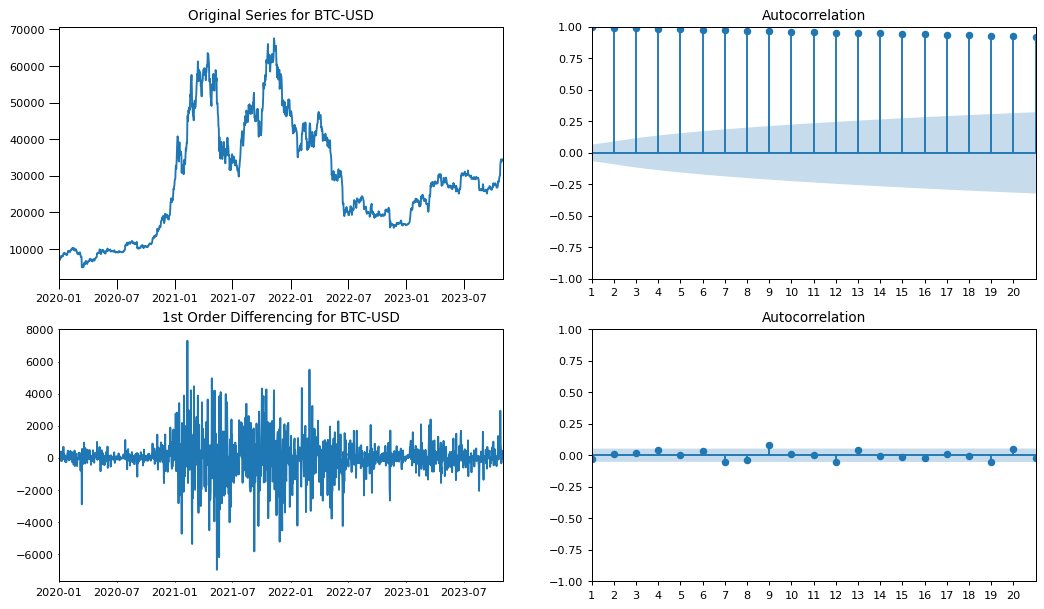

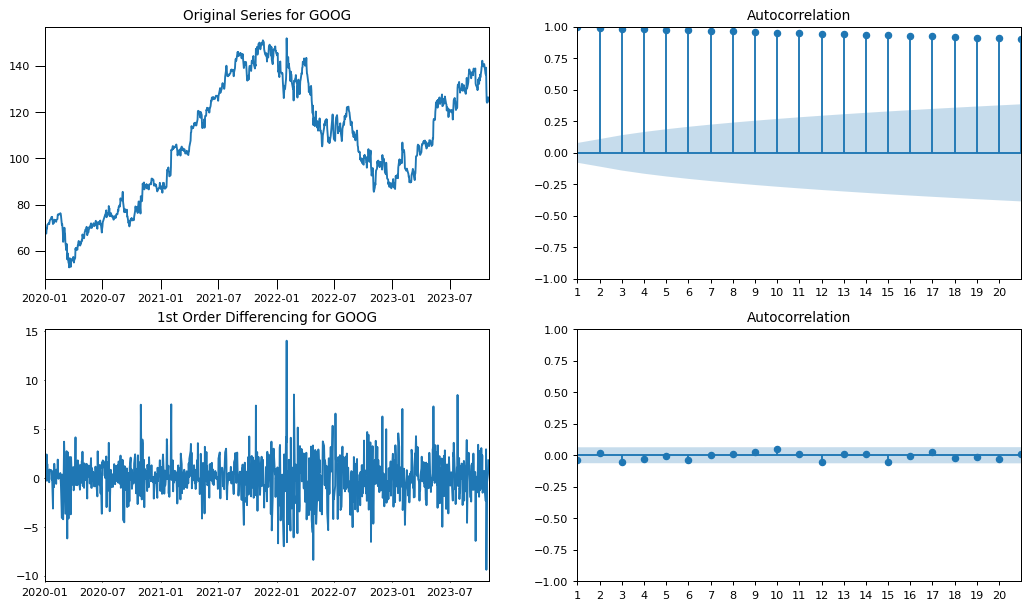

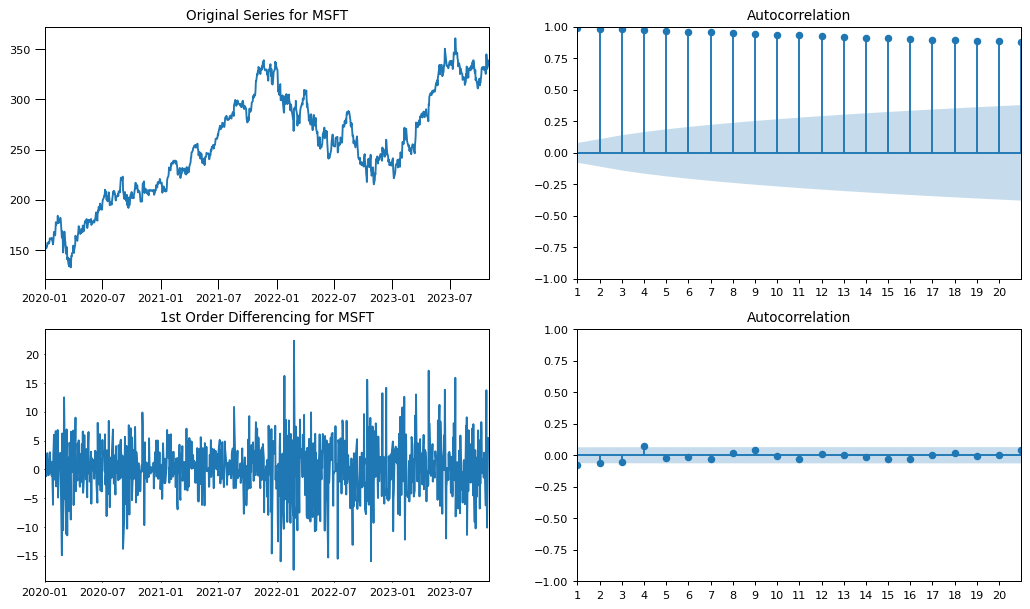

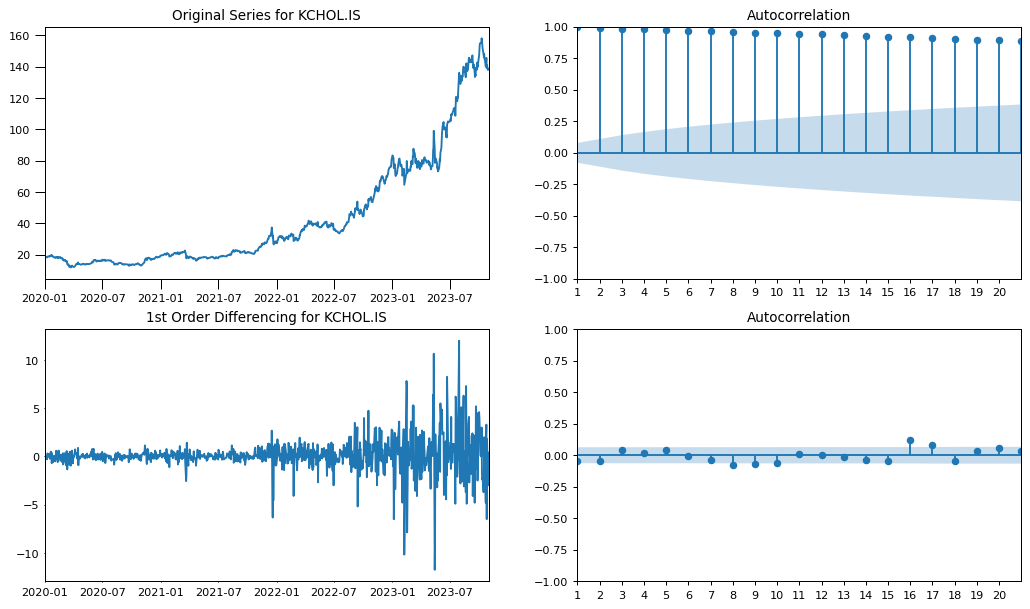

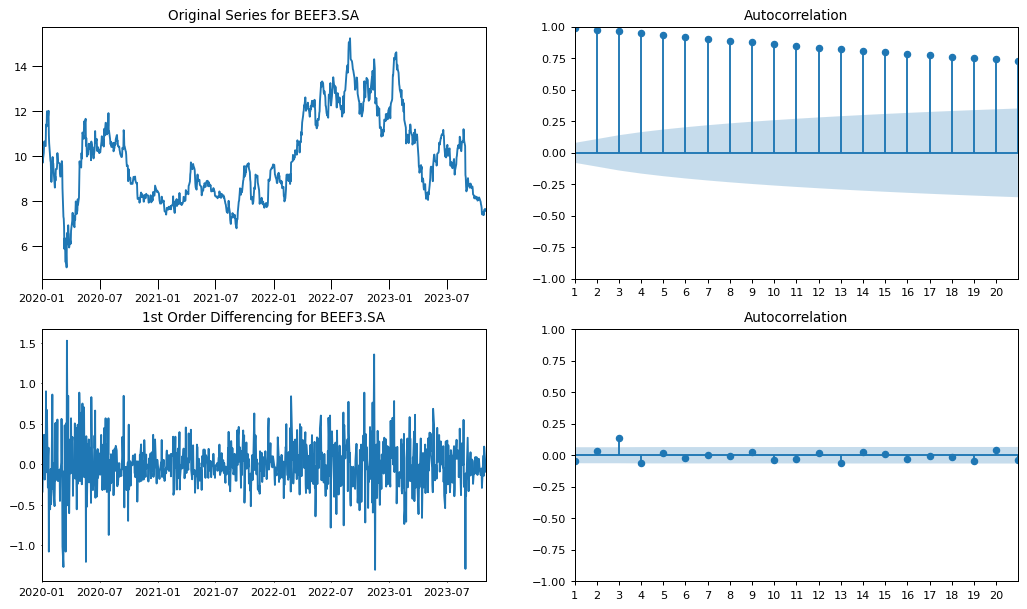

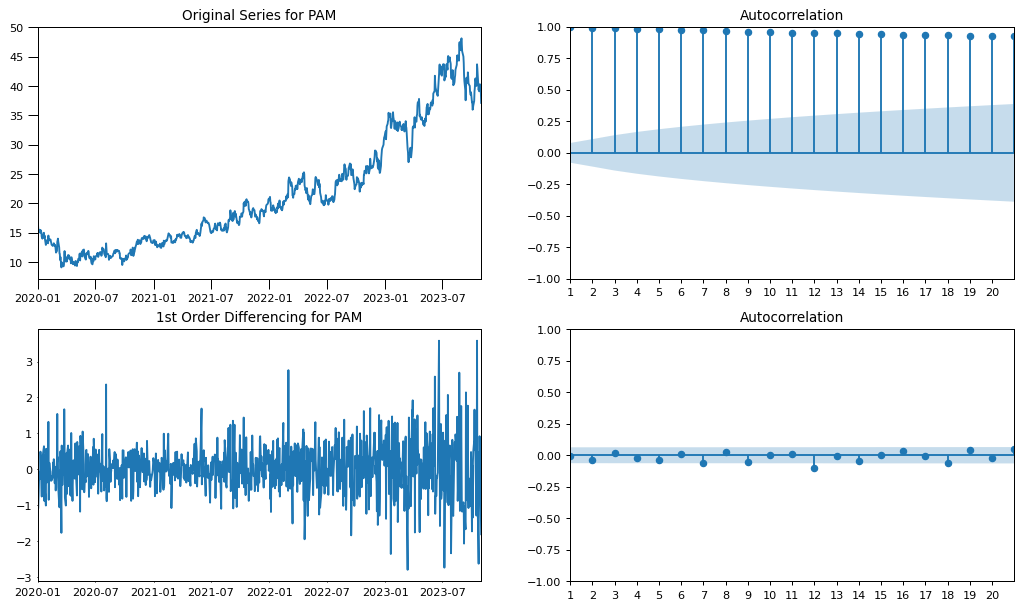

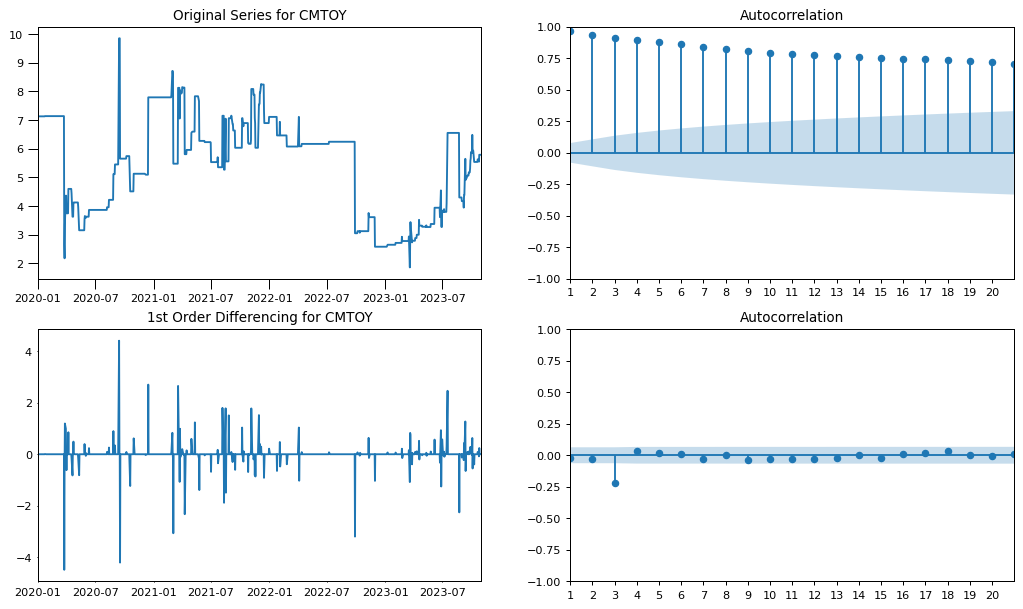

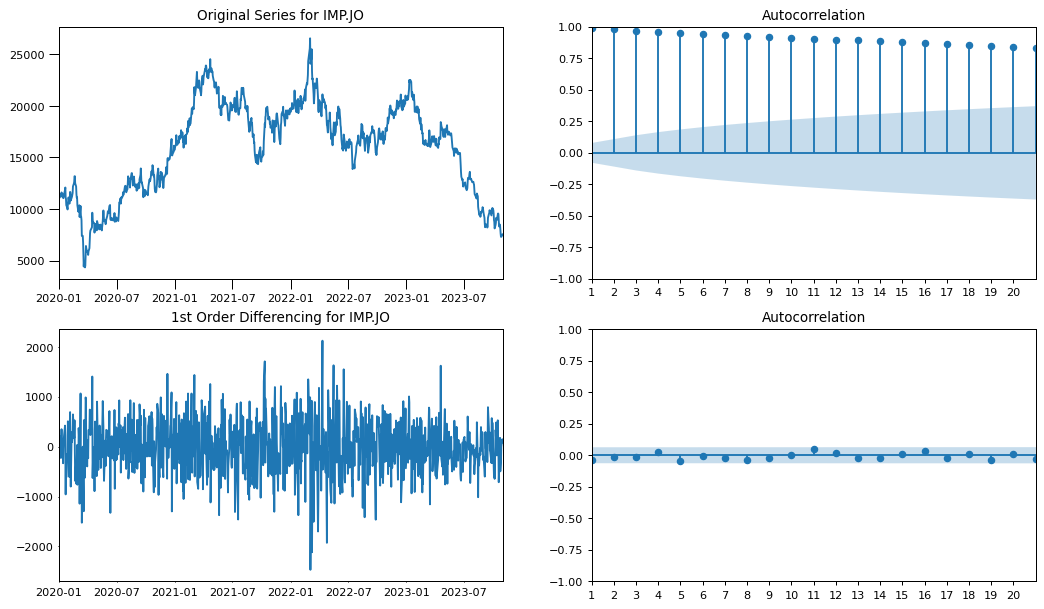

In [5]:
plt.rcParams.update({'figure.figsize':(14,8), 'figure.dpi':90, 'font.size':9})
for symbol in symbols:

    history = hist[symbol][['ds', 'y']]
    example_df = history.set_index('ds').squeeze()
    example_df.index = pd.DatetimeIndex(example_df.index).to_period('D')
    example_df.index = example_df.index.to_timestamp()

    fig, ax = plt.subplots(2, 2)

    # Original Series
    ax[0,0].set_xlim(dt.datetime(2020,1,1), dt.datetime(2023,11,1))
    ax[0,0].tick_params(size=8)
    ax[0,0].plot(example_df)
    ax[0,0].set_title(f'Original Series for {symbol}')
    ax[0, 1].set_xlim(1, 21)
    ax[0, 1].set_xticks(list(np.arange(1,21)))
    plot_acf(example_df.dropna(), ax=ax[0,1])

    # First order of differencing
    ax[1,0].set_xlim(dt.datetime(2020,1,1), dt.datetime(2023,11,1))
    ax[1,0].tick_params(size=1)
    ax[1,0].plot(example_df.diff())
    ax[1,0].set_title(f'1st Order Differencing for {symbol}')
    ax[1, 1].set_xlim(1, 21)
    ax[1, 1].set_xticks(list(np.arange(1,21)))
    plot_acf(example_df.diff().dropna(), ax=ax[1,1])

plt.show()

Since only the differenced series can be considered stationary, only the ACF tests for the differenced series are used to select q and the tests for the original series are just for illustration. The index of the last lag to be correlated to the time series next value (correlation score outside of the band) is equal to the q value.

Like for the PACF tests, for every time series considered, the ACF tests indicate no autocorrelation of the time series with its lags. This leads to a q value of 0 (no Moving Average component). This again suggests that the linearity of the model might be too simplistic to analyse these times series.

Based on the previous tests, the selected ARIMA parameters p d and q should be:
p = 0, d = 1, q = 0

However, this will lead the ARIMA model to learning nothing (no AR term, no MA term).
The differenced data is interpreted as purely uncorrelated to its lags and is considered a random noise.
Below, auto_arima is run to confirm or infirm this analysis.

In [6]:
auto_arima(y=history[['ds', 'y']].set_index('ds').squeeze(), 
           d = 1,
           seasonal = False,
           suppress_warnings = True)

C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

The auto_arima function confirms the above analysis.

In [7]:
p, d, q = (0, 1, 0)

Define the object which will output BUY/SELL/HOLD recommandations based on a Univariate Time Series Forecasting

In [8]:
class recommender():
    ''' 
    Simulates trading of stocks based on the predictions of a statistical tool.
    
    Parameters
    ----------
    initial_stock: Initial stock owned in the simulation
    max_trade: Maximum number of stock units to be traded when a recommendation is made
    intensity: The quantity of stock traded per period is proportional to this parameter
    min_delta: Minimum predicted relative variation of the stock price to 
               recommend a BUY or SELL action.
               
    '''
    def __init__(self, initial_stock=100, max_trade = 100, intensity = 3, min_delta = 0.05, seasonal_order = False):
        self.initial_stock = initial_stock
        self.max_trade = max_trade
        self.intensity = intensity*max_trade
        self.min_delta = min_delta
        self.seasonal_order = seasonal_order
        
    def __call__(self, args):
        ''' 
        Performs a series of recommendations with the following procedure loop:
        
        1) Fits predictor to the data up to current_date from this iteration 
        2) Makes a prediction of the future stock price (after current_date)
            within a specified timeframe
        3) Makes a recommendation (BUY/SELL/HOLD) based on that prediction
        4) Updates current_date to the last date the prediction covered
    
        This sequence is looped up until a final date is reached.
            
        Parameters
        ----------
        history: 
            pd.DataFrame
            DataFrame with the timeseries data to learn from
        start_date:
            Minimum date up to which the predictor will be fitted
        end_date:
            Last date that the predictions extend to
        interval:
            Number of days separating each prediction point
        periods:
            Integer, predictor is re-fitted to the data up to current date 
            after every "periods" predictions
        
        Returns
        ----------
        A plot of the predictions compared to the real data, the financial
        balance resulting from applying the successive recommendations
        '''
        history, start_date, end_date, periods, interval = args
        
        ## Initiate all the relevant values
        # Basic attributes
        self.stock = self.initial_stock
        initial_price= float(history.loc[(history['ds']-start_date).abs().idxmin()]['y'])
        self.initial_value = self.initial_stock*initial_price # Value of Initial Stock
        self.gains = 0
        
        # Historical attributes
        self.value_history = [] # History of the variation of the value of stock being held
        self.gain_history = [] # History of gains resulting from each successive traded stock
        self.net_gain_history = [] # History of gains resulting from each successive traded stock 
                                    # net of that traded stock value at the next period
                                    # The net gain will be negative if the price of the stock sold increases 
                                    # or if the price of the stock bought decreases
        self.action_history = [] # History of each trading action performed
        
        # Prepare history and self.predictions
        history = history[['ds', 'y']]
        history = history.set_index('ds').squeeze()
        mask = history.index<start_date
        forecast, prediction, next_date = self.forecast(history, start_date, periods, interval)
        # The way the predictor is fitted to the data will be displayed
        self.predictions = pd.Series(data = forecast) 
        
        # Loop predictions until end_date
        current_date = start_date
        plt.figure()
        plt.axvline(start_date, color = 'b') # Data fitted up to that point
        while current_date < end_date:
            # Fit the predictor to the history of stock prices and forecast
            forecast, prediction, next_date = self.forecast(history, current_date, periods, interval)
            plt.axvline(next_date, color = 'g') # A green vertical line indicates that prediction was made at this date
            self.recommend(history, prediction, current_date, next_date)
            self.predictions = pd.concat([self.predictions, forecast], ignore_index = False)
            current_date = next_date
        current_price = float(history.iloc[pd.Series(history.index-current_date).abs().idxmin()])
        
        # Next, print all the relevant historical attributes from this recommender to analyze its performance
        self.totalvalue_history = [round(a+b,1) for a,b in zip(self.gain_history, self.value_history)]
        print(f'\nThe Wallet gains per trade is (positive values = SELL)\n{list(zip(self.action_history, self.gain_history))}')
        print(f'\nThe Stock Value gains per trade is\n{list(zip(self.action_history, self.value_history))}')
        print(f'\nStock + Wallet value variation after trading: \n{list(zip(self.action_history, self.totalvalue_history))}')
        print(f'\nStock + Wallet Gains related to stock traded: \n{list(zip(self.action_history, self.net_gain_history))}')
        print(f'with sum of {round(sum(self.net_gain_history), 1)}')
        print(f'\nInitial stock (Quantity = {self.initial_stock}) value on {start_date}: {round(self.initial_value, 1)}')
        print(f'\nInitial stock (Quantity = {self.initial_stock}) value on {end_date}: {round(self.initial_stock*current_price, 1)}')
        print(f'\nFinal stock (Quantity = {round(self.stock, 3)}) value on {end_date}: {round(self.value, 1)}')
        print(f'\nGains from trading: {round(self.gains, 1)}')
        print(f'\nBalance compared to initial stock value on {end_date} (value owned if no trading) = {round(self.gains + self.value - self.initial_stock*current_price,1)}')
        print(f'\nBalance compared to initial stock value on {start_date}: {round(self.gains + self.value - self.initial_value,1)}')
        
        # Plot the predictions compared to real data
        MAE, self.error = self.MAE(history, self.predictions, start_date, end_date)
        print(f'\n{MAE = }')
        rolling = history.rolling(20)
        mean, std = rolling.mean(), rolling.std()
        bolling_min = pd.Series(mean-2*std)
        bolling_max = pd.Series(mean+2*std)
        plt.title(f'Forecast and real data compared for {symbol}')
        plt.plot(self.predictions, color = 'g', label = 'Predictions')
        plt.plot(history, ':', color = 'k', label = 'History')
        plt.plot(bolling_min, color = 'b', label = 'Top of Bollinger Band')
        plt.plot(bolling_max, color = 'r', label = 'Bottom of Bollinger Band')
        plt.legend()
        plt.xlabel('Date')
        plt.xticks(fontsize = 8) 
        plt.ylabel('Open')
        plt.show()
        
    def recommend(self, history, prediction, current_date, next_date):
        '''
        Performs a recommendation based on the predictor's forecast
        
        Parameters
        ----------
        forecast: The forecast of future stock prices
        current_date: Initial date of the forecast
        next_date: Last date of the forecast
        '''
        current_price = float(history.iloc[pd.Series(history.index-current_date).abs().idxmin()])
        self.value = self.stock*current_price # Current stock value
        actual_next_price = float(history.iloc[pd.Series(history.index-next_date).abs().idxmin()])
        
        relative = (prediction-current_price)/current_price # Relative price change
        action = ["SELL", "BUY"]
        
        # Determine action to take based on predicted relative price change
        if abs(relative) >= self.min_delta:
            t = prediction/current_price
            sign = int(t>1/t) - int(t<1/t) # equals 1 if prediction>current_price, else -1
            trade = round(max(-self.stock, min(self.intensity*(max(t, 1/t)-1), self.max_trade)*sign), 6)
                # The amount of stock traded (self.intensity*(max(t, 1/t)-1)) 
                # is higher when a larger price change is predicted
            self.stock += trade
            self.gains -= trade*current_price
            self.net = trade*(actual_next_price-current_price)
            self.action_history.append(action[int(relative>0)]) # BUY or SELL
        else:
            self.net = 0
            self.action_history.append("HOLD")
            trade = 0
    
        # Update value of stock being held
        self.value_history.append(round(self.stock*actual_next_price - self.value,1))
        self.value = self.stock*actual_next_price # Updated stock value
        self.gain_history.append(round(-trade*current_price,1))
        self.net_gain_history.append(round(self.net, 1))
    
    def forecast(self, history, current_date, periods, interval):
        to_fit = history[history.index<=current_date]
        to_fit.index = pd.DatetimeIndex(to_fit.index).to_period('D')
        if not self.seasonal_order:
            model = ARIMA(to_fit, order=(p, d, q))
        else:
            model = SARIMAX(to_fit, order=(p, d, q), seasonal_order = self.seasonal_order)
        predictor = model.fit()
        # Predictor is now fitted to data prior to current_date
        start = history.index[pd.Series(history.index-current_date).abs().idxmin()]
        next_date = current_date+pd.Timedelta(periods*interval, 'D')
        end = history.index[pd.Series(history.index-next_date).abs().idxmin()]
        forecast = predictor.predict(start, end).to_timestamp()
        forecast = forecast[forecast.index>=start]
        prediction = forecast.iloc[-1] # Predicted future stock price
        next_date = forecast.index[-1]
        return forecast, prediction, next_date

    def MAE(self, history, forecast, start_date, end_date):
        '''Returns the Mean Absolute Error of the forecast'''
        hmask = (history.index >= start_date) & (history.index <= end_date)
        fmask = (forecast.index >= start_date) & (forecast.index <= end_date)
        error = history[hmask].subtract(forecast[fmask]).abs().dropna()
        return round(error.mean(), 1), error

Choose what to forecast

In [9]:
symbols = ["BTC-USD", "GOOG", "MSFT", "KCHOL.IS", "BEEF3.SA", "PAM", "CMTOY", "IMP.JO"]
symbol = symbols[0]
history = hist[symbol][['ds', 'y']]

Set the time parameters

In [10]:
start_date = pd.to_datetime('2022-05-01') # Predictions begin after this date
end_date = pd.to_datetime('2023-10-25') # Predictions end after this date

interval = 30 # in days
periods = 2 # A recommendation is made every periods*interval days

Set the stock parameters

In [11]:
initial_stock = 10
max_trade = 10 # Maximum units of stock that can be traded after 1 recommendation is made
intensity = 3 # Price variation by 1/intensity results in trading max_trade
min_delta = 0.01 # Minimum predicted relative variation of stock price to perform a SELL or BUY action (0<min_delta<1)

Create a recommender object

In [12]:
recommend = recommender(initial_stock = initial_stock, 
                        max_trade = max_trade,
                        intensity = intensity,
                        min_delta = min_delta)

Perform the recommendation


The Wallet gains per trade is (positive values = SELL)
[('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0)]

The Stock Value gains per trade is
[('HOLD', -176049.5), ('HOLD', -4931.6), ('HOLD', 6728.0), ('HOLD', -33686.7), ('HOLD', 62808.3), ('HOLD', 50999.3), ('HOLD', 22450.9), ('HOLD', -41136.3), ('HOLD', 37091.7), ('HOLD', 43593.9)]

Stock + Wallet value variation after trading: 
[('HOLD', -176049.5), ('HOLD', -4931.6), ('HOLD', 6728.0), ('HOLD', -33686.7), ('HOLD', 62808.3), ('HOLD', 50999.3), ('HOLD', 22450.9), ('HOLD', -41136.3), ('HOLD', 37091.7), ('HOLD', 43593.9)]

Stock + Wallet Gains related to stock traded: 
[('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0)]
with sum of 0

Initial stock (Quantity = 10) value on 2022-05-01 00:00:00: 377132.7

Initial stock (Quantity = 10) value on 2023-10-25 00:00:0

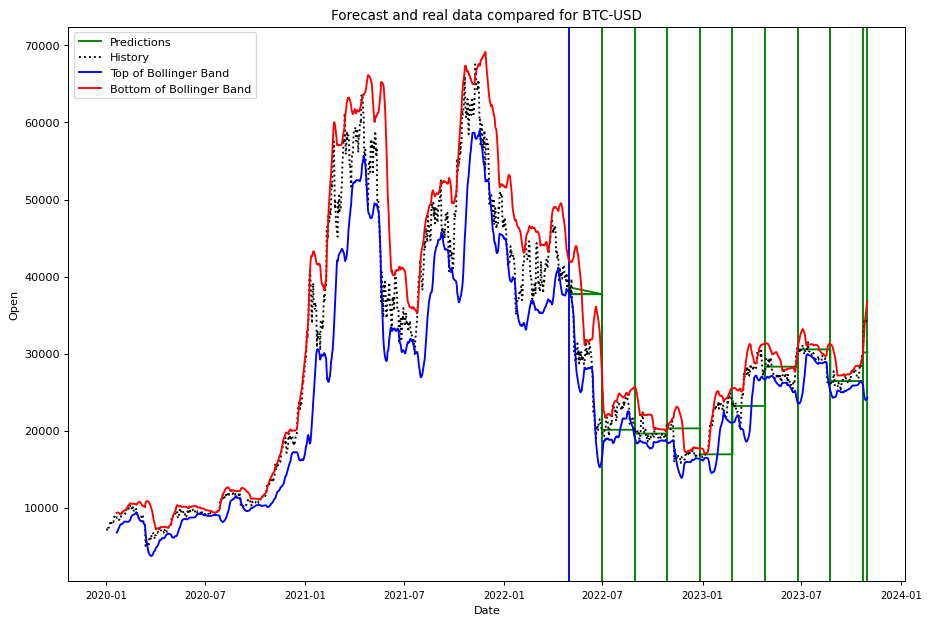

In [13]:
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':90, 'font.size':9})
args = (history, start_date, end_date, periods, interval)
recommend(args) # performs the recommendation

Predictions were made every {periods x interval} days starting from the blue vertical line, at dates corresponding to the green vertical lines.

Everytime a prediction was made, the model was then refitted up to the date the former prediction covered before a new prediction was made for {periods x interval} days later.

As can be seen from the graph above and from the recommendations made (HOLD), this ARIMA model is unable to learn from the data and always predict a constant price.

Below, another attempt is made with SARIMA (Seasonal component added)

In [14]:
D = nsdiffs(x = history[['ds', 'y']].set_index('ds').squeeze(),
            m=12, 
            max_D=2, 
            test='ocsb') # D is determined beforehand for faster computation

C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

In [15]:
print(D)

0


In [16]:
with StepwiseContext():
    model = auto_arima(y=history[['ds', 'y']].set_index('ds').squeeze(),
                       seasonal = True,
                       stepwise = True,
                       d = 1,
                       D = D,
                       m = 12,
                       suppress_warnings = True)

C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\GEOFF\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

In [17]:
print(model)

 ARIMA(2,1,2)(2,0,1)[12]          


C:\Users\GEOFF\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\GEOFF\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\GEOFF\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\GEOFF\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\GEOFF\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu


The Wallet gains per trade is (positive values = SELL)
[('HOLD', 0.0), ('SELL', 16760.8), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('HOLD', 0.0), ('BUY', -9132.3), ('HOLD', 0.0), ('BUY', -8908.2), ('HOLD', 0.0)]

The Stock Value gains per trade is
[('HOLD', -176049.5), ('SELL', -21281.3), ('HOLD', 6167.2), ('HOLD', -30878.8), ('HOLD', 57573.1), ('HOLD', 46748.4), ('BUY', 30436.3), ('HOLD', -39034.9), ('BUY', 45355.2), ('HOLD', 42836.3)]

Stock + Wallet value variation after trading: 
[('HOLD', -176049.5), ('SELL', -4520.5), ('HOLD', 6167.2), ('HOLD', -30878.8), ('HOLD', 57573.1), ('HOLD', 46748.4), ('BUY', 21304.0), ('HOLD', -39034.9), ('BUY', 36447.0), ('HOLD', 42836.3)]

Stock + Wallet Gains related to stock traded: 
[('HOLD', 0), ('SELL', 411.1), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('HOLD', 0), ('BUY', 724.5), ('HOLD', 0), ('BUY', 1250.1), ('HOLD', 0)]
with sum of 2385.7

Initial stock (Quantity = 10) value on 2022-05-01 00:00:00: 377132.7

Initial stock (Quantity = 10) valu

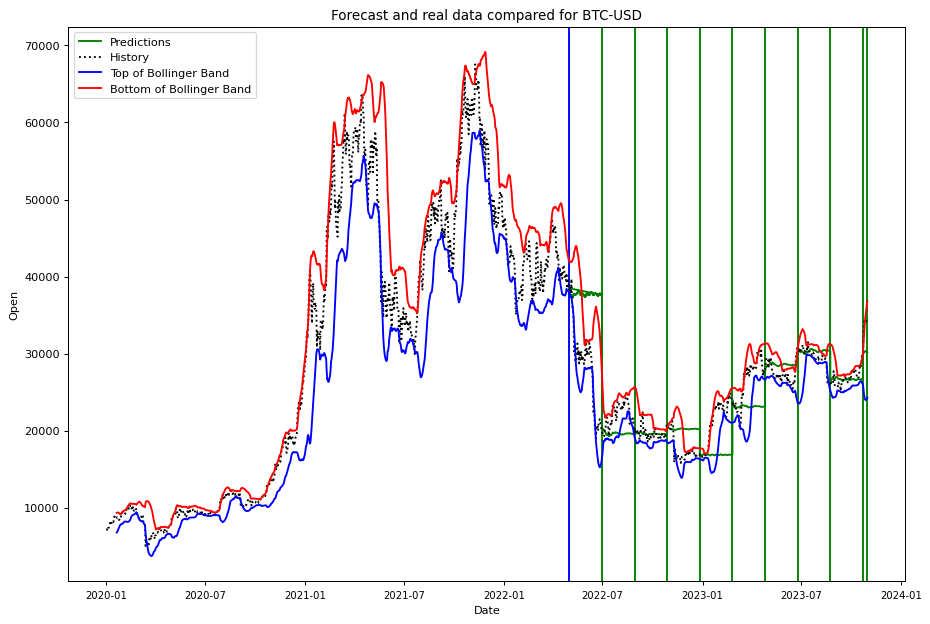

In [18]:
(p, d, q) = (2, 1, 2)
(P, D, Q, m) = (2, 0, 1, 12)
s_recommend = recommender(initial_stock = initial_stock,
                          max_trade = max_trade,
                          intensity = intensity,
                          min_delta = min_delta,
                          seasonal_order = (P, D, Q, m))
s_recommend(args) # performs the recommendation

Even with the seasonality component included, the results are roughly the same.

As a conclusion, it appears that the ARIMA and SARIMA linear models are not able to capture the complexities of these time series.